The aim in this notebook is to predict the total energy consumption in Germany using prediction time scales between 15 minutes and 24 hours.

First I import the needed python modules. 

In [1]:
import pandas as pd
import numpy as np
import scipy as sp



import pmdarima as pm
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

from datetime import date, time, datetime, timedelta

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import pickle

#add fullr and co 
import statsmodels.tsa.stattools as smtime

#We mainly use xgboost
from xgboost import XGBRegressor
import xgboost as xgb

#some skitlearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

#trials
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import sklearn.metrics as met
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
#needs newest statsmodel 0.14.0 
from statsmodels.tsa.seasonal import MSTL
from functions import *

Now using different method to find best xgboost version

The data is obtained from https://www.smard.de/home/downloadcenter/download-marktdaten/?downloadAttributes=%7B%22selectedCategory%22:2,%22selectedSubCategory%22:false,%22selectedRegion%22:false,%22selectedFileType%22:false%7D
 using the category 'Stromverbrauch' then the subcategory 'realisierter Stromverbrauch', then 'Deutschland', then the subcategory time intervall 'viertelstunde'.
                   
            
That request gets the power consumption of Germany in the best possible resolution of 15 minutes. To get all availble data (nearly 8 years) it is needed to download in six pieces. 

In [2]:
#path to the data
path='/home/tobias/ml-testing/energy/'
#getting the data which is in four pieces
real_power1=pd.read_csv(path+"Realisierter_Stromverbrauch_202012010000_202211142359.csv",delimiter=';')
real_power4=pd.read_csv(path+"Realisierter_Stromverbrauch_201501010000_201611302359.csv",delimiter=';')
real_power3=pd.read_csv(path+"Realisierter_Stromverbrauch_201612010000_201811302359.csv",delimiter=';')
real_power2=pd.read_csv(path+"Realisierter_Stromverbrauch_201812010000_202011302359.csv",delimiter=';')
real_power5=pd.read_csv(path+"Realisierter_Stromverbrauch_202211150000_202401022359_Viertelstunde.csv",delimiter=';')
real_power6=pd.read_csv(path+"Realisierter_Stromverbrauch_202401030000_202403112359_Viertelstunde.csv",delimiter=';')

Processing them. 

In [3]:
print(real_power5.columns)

Index(['Datum', 'Anfang', 'Ende',
       'Gesamt (Netzlast) [MWh] Originalauflösungen',
       'Residuallast [MWh] Originalauflösungen',
       'Pumpspeicher [MWh] Originalauflösungen'],
      dtype='object')


In [4]:
processed1=prepare_input(real_power1,old=True,str_convert=False)
processed2=prepare_input(real_power2,old=True,str_convert=False)
processed3=prepare_input(real_power3,old=True,str_convert=False)
processed4=prepare_input(real_power4,old=True,str_convert=False)
processed5=prepare_input(real_power5,old=False,str_convert=True)
processed6=prepare_input(real_power6,old=False,str_convert=True)

/home/tobias/ml-testing/energy/energy-timeseries/functions.py:558: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:561: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:558: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/

Combine them and plot for checking. 

dimensions of the data are (355488, 5)


Text(0, 0.5, 'total power [GW]')

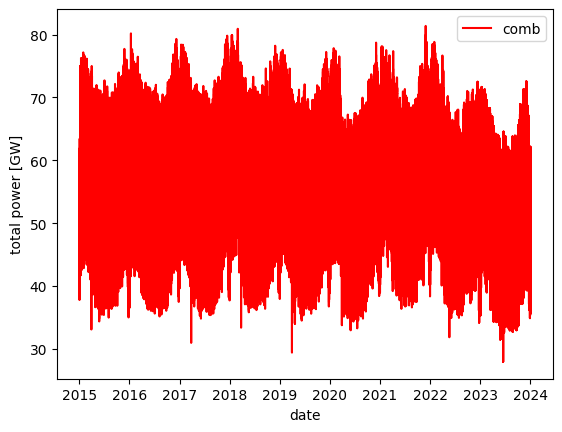

In [5]:
#date_time is set to index
processed1=processed1.set_index('date_time')
processed2=processed2.set_index('date_time')
processed3=processed3.set_index('date_time')
processed4=processed4.set_index('date_time')
processed5=processed5.set_index('date_time')
processed6=processed6.set_index('date_time')

#combining with concat
comb_real_power=pd.concat([processed4,processed3,processed2,processed1,processed5,processed5])
#reset index for easier handling
comb_real_power=comb_real_power.reset_index()
print(f"dimensions of the data are {comb_real_power.shape}")
plt.plot(comb_real_power['date_time'],comb_real_power['total_power']*4,'-',ms=1,color='red',label='comb') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("total power [GW]")

Including new worked. 

In [6]:
#freeing space 
real_power1=0
real_power2=0
real_power3=0
real_power4=0
real_power5=0
real_power6=0
processed1=0
processed2=0
processed3=0
processed4=0
processed5=0
processed6=0

No official predictions for now. 

In [7]:
#pred_power1=pd.read_csv(path+"Prognostizierter_Stromverbrauch_202012010000_202211142359.csv",delimiter=';')
#pred_power4=pd.read_csv(path+"Prognostizierter_Stromverbrauch_201501010000_201611302359_Viertelstunde.csv",delimiter=';')
#pred_power3=pd.read_csv(path+"Prognostizierter_Stromverbrauch_201612010000_201811302359_Viertelstunde.csv",delimiter=';')
#pred_power2=pd.read_csv(path+"Prognostizierter_Stromverbrauch_201812010000_202011302359_Viertelstunde.csv",delimiter=';')
#pred_power5=pd.read_csv(path+"Prognostizierter_Stromverbrauch_202211150000_202401022359_Viertelstunde.csv",delimiter=';')

In [59]:
print(comb_real_power.columns)

Index(['date_time', 'total_power', 'frac_day', 'frac_week', 'frac_year'], dtype='object')


In [61]:
from dateutil.easter import *

In [ ]:
Create date in full delta days relative to previous March 1. That get the normal holidays right and is close to the avrage 

In [ ]:
print(easter(2024))
print(comb_real_power.date_time.dt.year)
comb_real_power['year']=comb_real_power.date_time.dt.year.astype(int)
comb_real_power['month']=comb_real_power.date_time.dt.month.astype(int)
print(comb_real_power.dtypes)
print(easter(comb_real_power.year.iloc[0]))
comb_real_power['delta_easter']=0
#days from first march of the year, gest holidayts right given leap years
comb_real_power['delta_march']=0
for i in range(comb_real_power.shape[0]):
     comb_real_power['delta_easter'].iloc[i]=(comb_real_power['date_time'].iloc[i]-pd.to_datetime(easter(comb_real_power.year.iloc[i]))).days
     if comb_real_power.month.iloc[i]<2.5:
         comb_real_power['delta_march'].iloc[i]=(comb_real_power['date_time'].iloc[i]-datetime(comb_real_power['year'].iloc[i]-1,3,1)).days
     else:
         comb_real_power['delta_march'].iloc[i]=(comb_real_power['date_time'].iloc[i]-datetime(comb_real_power['year'].iloc[i],3,1)).days        
print(comb_real_power)
print(comb_real_power.dtypes)

2024-03-31
0         2015
1         2015
2         2015
3         2015
4         2015
          ... 
355483    2024
355484    2024
355485    2024
355486    2024
355487    2024
Name: date_time, Length: 355488, dtype: int64
date_time       datetime64[ns]
total_power            float64
frac_day               float64
frac_week              float64
frac_year              float64
year                     int64
delta_easter             int64
month                    int64
delta_march              int64
dtype: object
2015-04-05


/tmp/ipykernel_3320/1941346688.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb_real_power['delta_easter'].iloc[i]=(comb_real_power['date_time'].iloc[i]-pd.to_datetime(easter(comb_real_power.year.iloc[i]))).days
/tmp/ipykernel_3320/1941346688.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comb_real_power['delta_march'].iloc[i]=(comb_real_power['date_time'].iloc[i]-datetime(comb_real_power['year'].iloc[i]-1,3,1)).days
/tmp/ipykernel_3320/1941346688.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.

In [122]:
print(comb_real_power.delta_easter.value_counts())
comb_real_power['month']=comb_real_power.date_time.dt.month.astype(int)
print(comb_real_power)
s=datetime(comb_real_power.year.iloc[200000],3,1)
print(s)

 0     355487
-94         1
Name: delta_easter, dtype: int64
                 date_time  total_power  frac_day  frac_week  frac_year  year  \
0      2015-01-01 00:00:00     11.21000  0.000000   0.000000   0.000000  2015   
1      2015-01-01 00:15:00     11.11900  0.010417   0.001488   0.000029  2015   
2      2015-01-01 00:30:00     11.14500  0.020833   0.002976   0.000057  2015   
3      2015-01-01 00:45:00     11.12700  0.031250   0.004464   0.000086  2015   
4      2015-01-01 01:00:00     11.01000  0.041667   0.005952   0.000114  2015   
...                    ...          ...       ...        ...        ...   ...   
355483 2024-01-02 22:45:00     12.50175  0.947917   0.849702   0.004649  2024   
355484 2024-01-02 23:00:00     12.29050  0.958333   0.851190   0.004677  2024   
355485 2024-01-02 23:15:00     12.09550  0.968750   0.852679   0.004706  2024   
355486 2024-01-02 23:30:00     11.83150  0.979167   0.854167   0.004734  2024   
355487 2024-01-02 23:45:00     11.72175  0.98958

No gap prediction for now. 

In [8]:
#first now then to predict, here the 96 will be varies to get for many periods 
ser=series_to_supervised(comb_real_power.total_power,1,40)
print(ser.shape,ser[0:10,0:10])

(355447, 2) [[11.21  10.971]
 [11.119 11.157]
 [11.145 11.334]
 [11.127 11.587]
 [11.01  11.74 ]
 [10.923 11.888]
 [10.817 11.992]
 [10.705 12.072]
 [10.65  12.162]
 [10.547 12.175]]


Make to data frame

In [48]:
df_ser=pd.DataFrame(ser,columns=["now","to_predict"])
df_ser.loc[:,'frac_day']=comb_real_power.loc[0:df_ser.shape[0],'frac_day']
df_ser.loc[:,'frac_week']=comb_real_power.loc[0:df_ser.shape[0],'frac_week']
df_ser.loc[:,'frac_year']=comb_real_power.loc[0:df_ser.shape[0],'frac_year']
df_ser.loc[:,'date_time']=comb_real_power.loc[0:df_ser.shape[0],'date_time']

In [49]:
print(df_ser.columns)
frac1=int(df_ser.shape[0]*0.8)
print(frac1)
ser_train=df_ser.iloc[:frac1,:]
ser_test=df_ser.iloc[frac1:,:]
x_train=ser_train.loc[:,['now','frac_day', 'frac_week']]
y_train=ser_train.loc[:,'to_predict']
x_test=ser_test.loc[:,['now','frac_day', 'frac_week']]
y_test=ser_test.loc[:,'to_predict']

Index(['now', 'to_predict', 'frac_day', 'frac_week', 'frac_year', 'date_time'], dtype='object')
284357


In [11]:
model = XGBRegressor()
eval_set = [(x_test, y_test)]

In [12]:
model.fit(x_train, y_train, early_stopping_rounds=3, eval_metric="rmse", eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:8.72637
[1]	validation_0-rmse:5.98115


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-rmse:4.05915
[3]	validation_0-rmse:2.77229
[4]	validation_0-rmse:1.91063
[5]	validation_0-rmse:1.35527
[6]	validation_0-rmse:1.04882
[7]	validation_0-rmse:0.89292
[8]	validation_0-rmse:0.83386
[9]	validation_0-rmse:0.82157
[10]	validation_0-rmse:0.82523
[11]	validation_0-rmse:0.83745


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [13]:
y_pred = model.predict(x_test)

In [14]:
#uses best automatically, maybe always, but jsut fatsre wouldf be enough of adventage 
print(((y_test-y_pred)/np.mean(y_pred)).describe())

count    71090.000000
mean        -0.003215
std          0.062817
min         -0.436106
25%         -0.041268
50%         -0.005981
75%          0.036390
max          0.324543
Name: to_predict, dtype: float64


5.15% standard deviation, same as before (slightky different test sample), but should be faster. 

In [15]:
print(model.evals_result())
results = model.evals_result()
s=np.argmin(results['validation_0']['rmse'])
print(results['validation_0']['rmse'][s])

{'validation_0': OrderedDict([('rmse', [8.726367043507743, 5.981151046240265, 4.059152482707919, 2.7722926089609157, 1.9106342341060303, 1.3552725671644772, 1.0488226029800585, 0.8929219297122823, 0.833856560872419, 0.821565867551094, 0.825229762783422, 0.8374533338525445, 0.8406451458276729])])}
0.821565867551094


In [16]:
x_train2=ser_train.loc[:,['now','frac_day', 'frac_week', 'frac_year']]
y_train2=ser_train.loc[:,'to_predict']
x_test2=ser_test.loc[:,['now','frac_day', 'frac_week', 'frac_year']]
y_test2=ser_test.loc[:,'to_predict']
model2 = XGBRegressor()
eval_set2 = [(x_test2, y_test2)]

In [17]:
model2.fit(x_train2, y_train2, early_stopping_rounds=3, eval_metric="rmse", eval_set=eval_set2, verbose=True)

[0]	validation_0-rmse:8.67633


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:5.91779
[2]	validation_0-rmse:3.95216
[3]	validation_0-rmse:2.64223
[4]	validation_0-rmse:1.74275
[5]	validation_0-rmse:1.18308
[6]	validation_0-rmse:0.83600
[7]	validation_0-rmse:0.68515
[8]	validation_0-rmse:0.64317
[9]	validation_0-rmse:0.65284
[10]	validation_0-rmse:0.68257


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [18]:

y_pred2 = model2.predict(x_test2)
print((y_test2-y_pred2).describe())

y_pred2b = model2.predict(x_train2)
print((y_train2-y_pred2b).describe())

count    71090.000000
mean        -0.019810
std          0.642872
min         -4.657942
25%         -0.420338
50%         -0.030432
75%          0.380734
max          3.828303
Name: to_predict, dtype: float64
count    284357.000000
mean          0.554786
std           0.604625
min          -5.329725
25%           0.208173
50%           0.569069
75%           0.933573
max           3.212077
Name: to_predict, dtype: float64


In [27]:
#feature_train, target_train, feature_test, target_train, max depth of xgb, needs always be set *6 is equal to default), optional regularization alpha (larger less overfitting)
#now best n_est, is given back, that not more are run
def do_xgb_nest(feature_train, target_train, feature_test, target_test,max_depth,reg=0,silent=False,rounds=3):
    start_time=datetime.now()
    #no regularization option
    if reg==0:
        model = XGBRegressor(max_depth=max_depth)
    else:
        model = XGBRegressor(max_depth=max_depth,reg_alpha=reg)   
    eval_set = [(feature_test, target_test)]
    model.fit(feature_train, target_train, early_stopping_rounds=rounds, eval_metric="rmse", eval_set=eval_set, verbose=silent)
    results = model.evals_result()
    s=np.argmin(results['validation_0']['rmse'])
    print(results)
    pred_test=model.predict(feature_test)
    pred_train=model.predict(feature_train)
    test_scatter=np.std(pred_test-target_test)
    train_scatter=np.std(pred_train-target_train)
    test_m=np.mean(pred_test-target_test)
    train_m=np.mean(pred_train-target_train)
    test_rsme=np.sqrt((test_m**2+test_scatter**2))
    train_rsme=np.sqrt((train_m**2+train_scatter**2))   
    if silent==False:
        print(f"best n_estimator is {s+1}")
        print(f"mean of test {round(test_m,4)} points")
        print(f"mean of train {round(train_m,4)} points")
        print(f"rsme of test {round(test_rsme,4)} points")
        print(f"rsme of train {round(train_rsme,4)} points")
    #copy result to array which can be used by other function
    ar=np.zeros((6))
    ar[0]=reg
    ar[1]=max_depth
    ar[2]=train_rsme
    ar[3]=test_rsme
    ar[4]=s+1   
    ar[5]=test_m
    stop_time=datetime.now()
    if silent==False:
        print(f"xgb took {(stop_time-start_time)} seconds")
    return ar

In [28]:
test_res=do_xgb_nest(x_train2,y_train2,x_test2,y_test2,max_depth=4,rounds=200)
print(test_res)
#now better needed really many rounds, % optimum different than before because mean offset is relevant 

{'validation_0': OrderedDict([('rmse', [8.684334705667402, 5.926429947765957, 4.003741367621741, 2.6626710786329033, 1.7552473960543222, 1.196953873525858, 0.8891154792670543, 0.8003368331096721, 0.811863722473144, 0.8423328187352529, 0.8740848759917604, 0.900006488605535, 0.915246746382955, 0.916865962379068, 0.9250429261614586, 0.9205267104994345, 0.9205044872351494, 0.9196173381749456, 0.9168897030704409, 0.9123470337898404, 0.9093883035196664, 0.9065473464920333, 0.901291406934609, 0.8945349014151759, 0.8917748298878, 0.8875070614472423, 0.8762454474060539, 0.874070819567189, 0.8716836025244004, 0.8636597745645728, 0.858971878175915, 0.8571474019858969, 0.8563182823136193, 0.8481581604271486, 0.8420520801905951, 0.8367863296040555, 0.8342189707481394, 0.8326730359650418, 0.8290481455394164, 0.8260433936255905, 0.822865047553991, 0.821876674112275, 0.8170954879386474, 0.8134502644042604, 0.8123123663031787, 0.8087707929516353, 0.8030185391916697, 0.8003397628832394, 0.79768195643138

In [57]:
test_res2=do_xgb(x_train2,y_train2,x_test2,y_test2,max_depth=4)

standard deviation of test 2.2572 points
standard deviation of train 2.4944  points
standard deviation of prediction-test 0.534 points
standard deviation of prediction-train 0.478 points
xgb took 0:00:03.794046 seconds


In [61]:
av2=np.mean(y_test2)
av1=np.mean(y_train2)
print(av2,av1)
print(0.8/13)

13.019716289210859 14.23729437291855
0.06153846153846154


Yes is faster now, when round number is small. Also rsme used which helps to reduce the bias. 

In [36]:
def loop_reg_nest(feature_train, target_train, feature_test, target_test,max_depth=6,reg_start=0.01,reg_increase=1.414,reg_steps=20,save=False,file_name=None,regression=True,silent=False,rounds=3,limit=1.05):
    #that takes now some time
    resb=np.zeros((6,reg_steps))
    for i in range(reg_steps):
        if silent==False:
            print(f"doing case {i}")
        regularization=reg_start*reg_increase**i
        #regression
        if regression==True:
            ar=do_xgb_nest(feature_train,target_train,feature_test,target_test,max_depth=max_depth,rounds=rounds,reg=regularization,silent=silent)  
                
        #classification not yet implemented
        else:
            ar=do_xgb_class(feature_train, target_train, feature_test, target_test,max_depth=max_depth,reg=regularization,silent=silent)
        resb[:,i]=ar           
        #early stopping
        if ar[2]>ar[3]*limit:
             return resb[:,:i]
    #saved now only at the end seems stable enough now
    if save==True:
        np.savetxt(file_name, resb) 
    else:
        return resb

In [38]:
test_loop=loop_reg_nest(ser_train.loc[:,['now','frac_day', 'frac_week', 'frac_year']],ser_train.to_predict,ser_test.loc[:,['now','frac_day', 'frac_week', 'frac_year']],ser_test.to_predict,max_depth=4,reg_start=0.001,reg_increase=1.414,reg_steps=40,save=False,regression=True,silent=False,rounds=100,limit=1.8)

40
doing case 0
100


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'validation_0': OrderedDict([('rmse', [8.684334707022137, 5.926429953257435, 4.003741442569259, 2.6626302006492892, 1.755210858351802, 1.1969330448497146, 0.8891261606637167, 0.8003725433239873, 0.8119174055943813, 0.8423885964321296, 0.8741440653736583, 0.9000667137098077, 0.9152936484622636, 0.916913264477066, 0.9250915275444307, 0.9205607677550189, 0.9205388875793071, 0.9196514710655628, 0.9169218112700415, 0.9123781826745576, 0.9094131465912078, 0.9065815119782192, 0.9013243218112837, 0.8945663514843172, 0.8918064424089108, 0.8875394178951475, 0.8762765739772578, 0.8740789280508314, 0.8716296096589206, 0.8636393856751026, 0.8581670843227431, 0.8567294936034998, 0.8491899396912136, 0.8463967732943172, 0.8437680939115786, 0.8426171070683517, 0.8398650989138592, 0.8363275947007556, 0.8325229752912022, 0.8290660606432306, 0.8239873966982305, 0.8217060860955077, 0.8191610612262111, 0.8167835614041059, 0.8129360736433141, 0.8113365826440688, 0.8090655255255725, 0.80749409230787, 0.80371

{'validation_0': OrderedDict([('rmse', [8.68433475174541, 5.926430083327471, 4.0037415665030816, 2.6626712790407394, 1.7552475841934374, 1.1969540435977812, 0.8891156293222395, 0.8003369097741045, 0.8118638015752824, 0.8423328691054659, 0.8740849233756187, 0.9000066202317527, 0.9152468566243902, 0.9168661479823013, 0.9250431674703995, 0.9205269495032067, 0.9205047402726282, 0.919617669484497, 0.9168901368120633, 0.9123476148802547, 0.909388913857816, 0.9065479647392521, 0.9012921046326091, 0.8945358091380738, 0.8917756877215954, 0.8875079397257489, 0.8762463253487012, 0.8740713449881182, 0.8716841243147128, 0.8636603493500163, 0.8589726698096806, 0.8571482388462692, 0.8563191180573408, 0.8481590274648805, 0.8420529682187496, 0.8367872078141773, 0.8342198394834519, 0.8326738976261328, 0.8290490104582828, 0.8260442584850437, 0.8228658812267843, 0.821877471697572, 0.8170963220699474, 0.813451110698048, 0.812313205674263, 0.8087716010321607, 0.8030193227242871, 0.8003405500715859, 0.797682

best n_estimator is 100
mean of test 0.4599 points
mean of train 0.0 points
rsme of test 0.7072 points
rsme of train 0.4775 points
xgb took 0:00:07.685592 seconds
doing case 8
100
{'validation_0': OrderedDict([('rmse', [8.684332070932916, 5.926427642390712, 4.003739368226338, 2.6626278794989444, 1.755208006432436, 1.1969301249584787, 0.889124137424204, 0.8003716624144346, 0.8119174912375327, 0.8404314234668495, 0.8743909654400746, 0.9019563530574488, 0.9166012811174565, 0.9242027024730893, 0.9316090181445308, 0.9217712081423652, 0.921279004378927, 0.9188987225460732, 0.9188639046823145, 0.9104932956410426, 0.9103999206117622, 0.901922158658759, 0.896788944489252, 0.8937369386175197, 0.8894590985306959, 0.8888515655331222, 0.8816451959484516, 0.8805017779519595, 0.8709170910474318, 0.866038654192388, 0.8570390525861257, 0.8536730884107192, 0.8495838860725257, 0.8434835520159439, 0.8387896373439797, 0.8340327254841136, 0.830413049854704, 0.8256298923331808, 0.8245169753431216, 0.82531449

best n_estimator is 100
mean of test 0.4631 points
mean of train 0.0 points
rsme of test 0.7139 points
rsme of train 0.4754 points
xgb took 0:00:11.612473 seconds
doing case 12
100
{'validation_0': OrderedDict([('rmse', [8.68435161575225, 5.9264482953421345, 4.003760975720087, 2.6626502889444006, 1.7552326902263098, 1.1969558824682998, 0.8891464773182913, 0.8003878052931241, 0.8119285485463311, 0.8404385733032886, 0.8743937422361943, 0.9019587615644087, 0.9166022804011899, 0.9242011941258486, 0.9316080674138554, 0.9217715807597769, 0.9212783522902888, 0.9188978235218166, 0.9188626579490214, 0.9104953540488188, 0.910401176531516, 0.9019235592128237, 0.8967915385148346, 0.8937393666562984, 0.8894612642467085, 0.8888538056711336, 0.8816475036047984, 0.8805036696982829, 0.8709192725526279, 0.8660410713145386, 0.8570414281341565, 0.8536753522782241, 0.8495853515790772, 0.843485556604818, 0.8387914805154547, 0.834034521785999, 0.8304143934835857, 0.8256316842647421, 0.8245183958587847, 0.825

best n_estimator is 100
mean of test 0.4631 points
mean of train 0.0 points
rsme of test 0.7106 points
rsme of train 0.4757 points
xgb took 0:00:10.399906 seconds
doing case 16
100
{'validation_0': OrderedDict([('rmse', [8.684355857067048, 5.926455437331348, 4.003769593958943, 2.662659948306433, 1.7552426539546804, 1.1969649444231147, 0.8891532790295583, 0.8003907984531449, 0.8119305061530027, 0.8404392359198926, 0.8743938826400391, 0.901962135774793, 0.9166046816210258, 0.9242065762153737, 0.9316166702986249, 0.9217831055645305, 0.9212907656976318, 0.9189102719140975, 0.9188753680281035, 0.9105215324875314, 0.91042639877761, 0.9019480415226567, 0.8968183720551853, 0.8937653290727503, 0.889485188907139, 0.8888766904932374, 0.8816707926318561, 0.8805281979173119, 0.8709426987904401, 0.8660657070045238, 0.857063029158307, 0.8536981437309259, 0.8492868188631204, 0.8430900644297693, 0.8384373026282679, 0.833680834134915, 0.8300609855836815, 0.8255366187984216, 0.824480812993381, 0.82373714

best n_estimator is 99
mean of test 0.47 points
mean of train 0.0 points
rsme of test 0.7105 points
rsme of train 0.4771 points
xgb took 0:00:09.542823 seconds
doing case 20
100
{'validation_0': OrderedDict([('rmse', [8.68436961355232, 5.926480157733328, 4.003800351384901, 2.6626942518072267, 1.75527831353434, 1.1969955713212972, 0.8891761139443538, 0.8003994631260487, 0.8119351750491733, 0.8404395989082909, 0.8743932211479699, 0.9019740074372753, 0.9166133023086848, 0.9242327981469287, 0.931658066519319, 0.9218349593372076, 0.9213483772586964, 0.9189613206820813, 0.9189280456239116, 0.9106277817658087, 0.9105300664598993, 0.9020494943198909, 0.8969280968905283, 0.8938742750199256, 0.8896155205365817, 0.8890086529123421, 0.8818062633765045, 0.8806680841519361, 0.8710135631359679, 0.8661269976641177, 0.8571670153405575, 0.8538015235555126, 0.8502418536258929, 0.8440621993760951, 0.8393935375083977, 0.8344356050730728, 0.8307472865824523, 0.8274529519333931, 0.8264335046530563, 0.8243932

best n_estimator is 100
mean of test 0.4795 points
mean of train 0.0 points
rsme of test 0.7153 points
rsme of train 0.4769 points
xgb took 0:00:09.239898 seconds
doing case 24
100
{'validation_0': OrderedDict([('rmse', [8.684419772660878, 5.926574595122128, 4.003916835258009, 2.6628257040102232, 1.75541654673256, 1.1971120902344445, 0.8892598163130554, 0.8004246596602019, 0.8119445603601763, 0.8404313837606154, 0.8743844194013609, 0.9020159845420779, 0.9166424186458964, 0.9243199080810398, 0.9326677242684652, 0.9224451774046468, 0.9220464279180703, 0.9231629154310642, 0.923726279164524, 0.9214045256012372, 0.9171448257916842, 0.9111083180347301, 0.9069621003376568, 0.9017503989710766, 0.8992593710569974, 0.8872423730736121, 0.8791573079862447, 0.875001675950768, 0.8663942534610235, 0.8655248775636647, 0.8606257639857814, 0.8588484757803012, 0.8533486213316253, 0.8477540792546076, 0.8467059936749588, 0.842281699879845, 0.8394741205713047, 0.8362671299966776, 0.833480186170521, 0.830812

best n_estimator is 100
mean of test 0.4579 points
mean of train -0.0 points
rsme of test 0.7059 points
rsme of train 0.4729 points
xgb took 0:00:10.964061 seconds
doing case 28
100
{'validation_0': OrderedDict([('rmse', [8.68468390369984, 5.927016715227668, 4.004450356277907, 2.6634692039500205, 1.7560908808768787, 1.1976863315749562, 0.8900051219416291, 0.8003185366270775, 0.8117975108898169, 0.8415017818149508, 0.8749080252759512, 0.9026719768498409, 0.9163504950946416, 0.9234877326919276, 0.9311866665331, 0.9234711696780321, 0.9270058134708912, 0.9268998583539095, 0.9250968178031738, 0.919261215806667, 0.9179356145411971, 0.904932188344973, 0.9006196338906508, 0.8973359526485124, 0.8961767986135795, 0.8909354397681419, 0.8885365057563848, 0.8822202166882745, 0.8784913533354065, 0.8771623695444477, 0.8701182496708201, 0.8678073614113946, 0.865024347942043, 0.852645240999921, 0.8486204467184034, 0.8460108160965132, 0.8437466514140457, 0.8387066840101806, 0.8340492923071782, 0.8309851

best n_estimator is 100
mean of test 0.4558 points
mean of train 0.0 points
rsme of test 0.7054 points
rsme of train 0.4836 points
xgb took 0:00:09.923548 seconds
doing case 32
100
{'validation_0': OrderedDict([('rmse', [8.685681040330067, 5.924191968605167, 4.001647539662603, 2.646945527749174, 1.7424560503242392, 1.180812660498296, 0.8901928477720683, 0.7931711450770413, 0.795903049233284, 0.8241919677168557, 0.8691088690474229, 0.8959124370733247, 0.9067702229469874, 0.9179851116733648, 0.9233421183118762, 0.9320998343289325, 0.9284741925860224, 0.9228380611884408, 0.9168682717103396, 0.9157310398348908, 0.9137833097610085, 0.9108933873333668, 0.907736608018795, 0.9056073474488531, 0.8986941005985934, 0.8929141164842688, 0.8881507669627043, 0.8832639616533415, 0.8817552655062055, 0.8752256346853229, 0.8707224519547186, 0.8608690308019098, 0.857785823452041, 0.8526944372646672, 0.8501049165829144, 0.8439897283170731, 0.8407606461844179, 0.8392976629944995, 0.8336929545465008, 0.83297

best n_estimator is 100
mean of test 0.4773 points
mean of train -0.0005 points
rsme of test 0.7337 points
rsme of train 0.5096 points
xgb took 0:00:09.668133 seconds
doing case 36
100
{'validation_0': OrderedDict([('rmse', [8.68763902252917, 5.9301505084181905, 4.0107228620130355, 2.643185785708199, 1.746885160849466, 1.1963012011106897, 0.8911367769099438, 0.801044672334924, 0.7986516625631769, 0.8216873298476298, 0.8631361152465807, 0.8907645854833888, 0.9185721280755126, 0.9324787362579132, 0.9398275068711005, 0.9500373970347686, 0.948529558865456, 0.9530169258821243, 0.9479914837345574, 0.9477559422824269, 0.9397181132142173, 0.9342303177791013, 0.926400642858193, 0.9225604836785506, 0.9198138416852837, 0.9163923196417365, 0.9037521490053637, 0.900999904994268, 0.8967158991265648, 0.8909450181136888, 0.8862453903144097, 0.8853324275481562, 0.8792415690742125, 0.8771089870781301, 0.8721171292547838, 0.8652965219199245, 0.8637106625416789, 0.8622766271256358, 0.8597940083544251, 0.8

best n_estimator is 100
mean of test 0.4885 points
mean of train -0.0028 points
rsme of test 0.7571 points
rsme of train 0.5479 points
xgb took 0:00:10.226226 seconds


Now doing rounds, since early stopping does not seem to work well for the data. There is niw a clear difference in the offset between train and test, strange. 

Text(0.5, 1.0, '4 features')

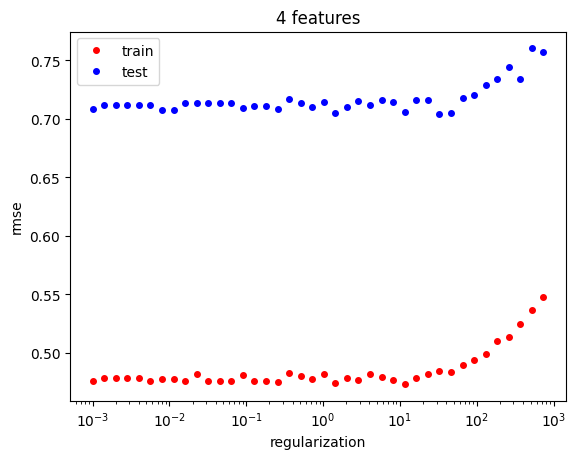

In [40]:

plt.plot(test_loop[0],test_loop[2],'o',ms=4,color='red',label="train")  
plt.plot(test_loop[0],test_loop[3],'o',ms=4,color='blue',label="test")  
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("regularization")
plt.ylabel("rmse")
plt.xscale("log")
plt.title("4 features")

More scatter than before, 10 and 12, 15 rounds not enough. I am not convinvced that this method really makes it better. Now seems to work with 25, somewhat doubtful, that this still really better, speed wise. 

Text(0.5, 1.0, '4 features')

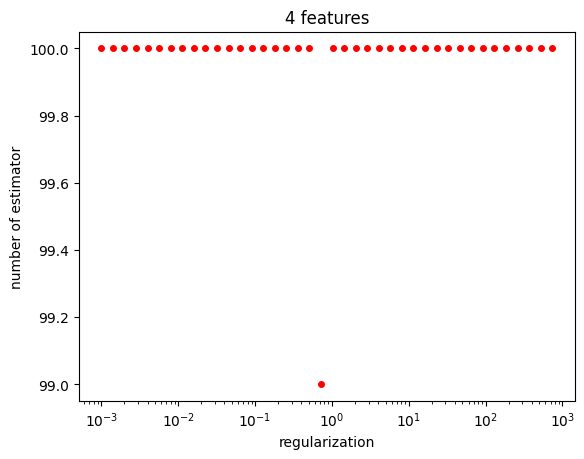

In [42]:

plt.plot(test_loop[0],test_loop[4],'o',ms=4,color='red',label="train")  
#plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("regularization")
plt.ylabel("number of estimator")
plt.xscale("log")
plt.title("4 features")

Text(0.5, 1.0, '4 features')

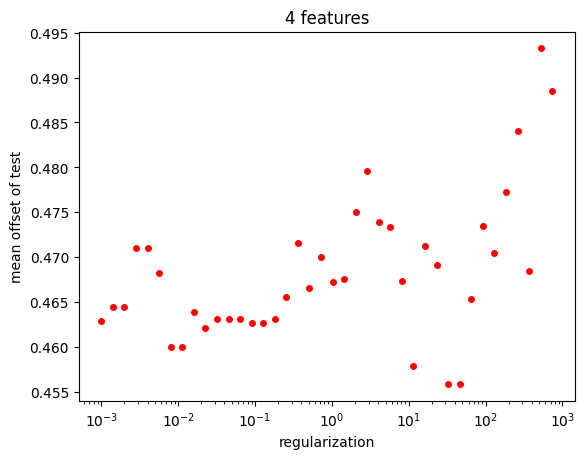

In [45]:

plt.plot(test_loop[0],test_loop[5],'o',ms=4,color='red',label="train")  
#plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("regularization")
plt.ylabel("mean offset of test")
plt.xscale("log")
plt.title("4 features")

Looking in prediction offset. 

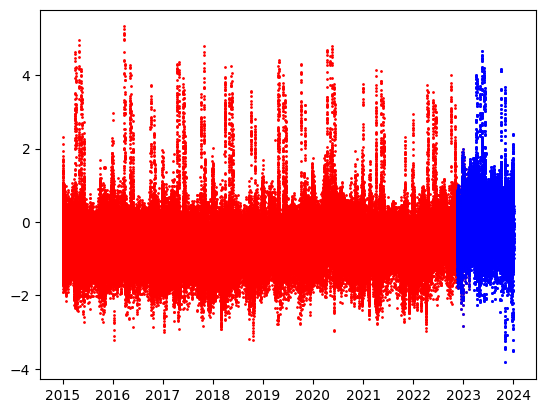

In [55]:
#print(ser_train)
#y_pred2 = model2.predict(x_test2)
#print((y_test2-y_pred2).describe())

#y_pred2b = model2.predict(x_train2)
plt.plot(ser_train.date_time,y_pred2b-y_train,'o',ms=1,color='red',label="train")  
plt.plot(ser_test.date_time,y_pred2-y_test,'o',ms=1,color='blue',label="test")  

In [ ]:
Seems to be genral offset, affected most, likely Ukraine war related. 

(18993.0, 19358.0)

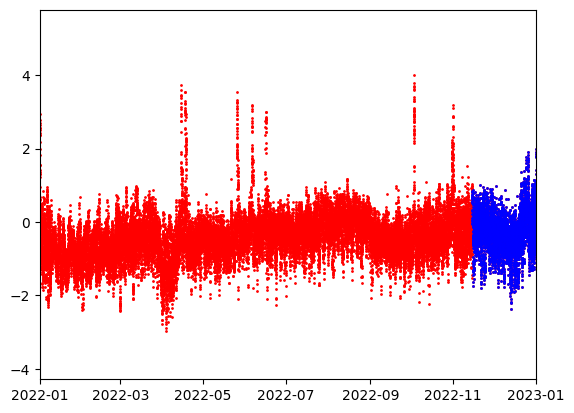

In [57]:
plt.plot(ser_train.date_time,y_pred2b-y_train,'o',ms=1,color='red',label="train")  
plt.plot(ser_test.date_time,y_pred2-y_test,'o',ms=1,color='blue',label="test")  
plt.xlim(datetime(2022,1,1),datetime(2023,1,1))

Easter dates a problem also some others. 

In [26]:
#plt.bar(ser_train.loc[:,['now','frac_day', 'frac_week', 'frac_year']].columns, xmodel2.feature_importances_)
#plt.xticks(rotation = 90)
#plt.show()

NameError: name 'xmodel2' is not defined

In [63]:
def find_best2(dat,delta=3):
    min_p=np.argmin(dat[3])
    est=np.zeros((3))
    print(dat[0,min_p])
    print(dat[0:4,min_p-delta:min_p+delta])
    if min_p-delta>=0:
        val,cov=sp.optimize.curve_fit(log_quat,dat[0,min_p-delta:min_p+delta],dat[3,min_p-delta:min_p+delta],p0=est)
    else:
        val,cov=sp.optimize.curve_fit(log_quat,dat[0,0:min_p+delta],dat[3,0:min_p+delta],p0=est)
    print(val)
    min_p1=10**dev_quat(val[0],val[1],val[2])
    print(min_p1)
    print(dat)
    s=np.argmin(np.abs(min_p1-dat[3]))
    print(s,dat[4,s])
    return min_p1, dat[4,s], s
    

In [66]:
#xmodel3=XGBRegressor(alpha=best_reg).fit(df_ser.loc[:,['now','frac_day', 'frac_week', 'frac_year']],df_ser.loc[:,'to_predict'])
#xmodel3.save_model("xgb_model_096.json")


In [67]:
#xmodel4=XGBRegressor()
#xmodel4.load_model("xgb_model_096.json")

Basic works, now making all to a function that it can be produced for a number of time deltas. 
First for single time delta. 

Should give out standard deviation of test at some point also. 

In [64]:
#parameters data frame, gap to wanted prediction
def find_fit_best_reg2(df,gap,now_points=1,test_frac=0.8,max_depth=4,reg_start=0.001,reg_increase=1.414,reg_steps=4,delta=4,filename=None,save=True,rounds=25):
    print(gap)
    ser=series_to_supervised(df.total_power,now_points,gap)
    df_ser=pd.DataFrame(ser,columns=["now","to_predict"])
    df_ser.loc[:,'frac_day']=df.loc[0:df_ser.shape[0],'frac_day']
    df_ser.loc[:,'frac_week']=df.loc[0:df_ser.shape[0],'frac_week']
    df_ser.loc[:,'frac_year']=df.loc[0:df_ser.shape[0],'frac_year']
    print(df_ser.shape)
    print(df_ser.columns)
    frac1=int(df_ser.shape[0]*0.8)
    print(frac1)
    ser_train=df_ser.iloc[:frac1,:]
    ser_test=df_ser.iloc[frac1:,:]
    print(reg_steps)
    stat_reg=loop_reg_nest(ser_train.loc[:,['now','frac_day', 'frac_week', 'frac_year']],ser_train.to_predict,ser_test.loc[:,['now','frac_day', 'frac_week', 'frac_year']],ser_test.to_predict,max_depth=max_depth,reg_start=reg_start,reg_increase=reg_increase,reg_steps=reg_steps,save=False,regression=True,silent=False,rounds=rounds)
    print(stat_reg)
    best_reg, best_nest,s=find_best2(stat_reg,delta=delta)
    print(best_nest)
    xmodel=XGBRegressor(alpha=best_reg,max_depth=max_depth,n_estimators=int(best_nest)).fit(df_ser.loc[:,['now','frac_day', 'frac_week', 'frac_year']],df_ser.loc[:,'to_predict'])
    test_rsme=stat_reg[3,s]
    print(test_rsme)
    if save==True:
        xmodel.save_model(filename)
        return test_rsme
    else:
        return xmodel, test_rsme

In [79]:
test_rsme=find_fit_best_reg2(comb_real_power,1,reg_steps=4,rounds=25,filename="xgb2_model_001.json")

1
[[11.21    11.145  ]
 [11.119   11.127  ]
 [11.145   11.01   ]
 ...
 [12.50175 12.0955 ]
 [12.2905  11.8315 ]
 [12.0955  11.72175]]
(355486, 5)
Index(['now', 'to_predict', 'frac_day', 'frac_week', 'frac_year'], dtype='object')
284388
4
             now  to_predict  frac_day  frac_week  frac_year
0       11.21000    11.14500  0.000000   0.000000   0.000000
1       11.11900    11.12700  0.010417   0.001488   0.000029
2       11.14500    11.01000  0.020833   0.002976   0.000057
3       11.12700    10.92300  0.031250   0.004464   0.000086
4       11.01000    10.81700  0.041667   0.005952   0.000114
...          ...         ...       ...        ...        ...
284383  16.76475    17.17400  0.322917   0.188988   0.110398
284384  17.07075    17.25125  0.333333   0.190476   0.110427
284385  17.17400    17.28650  0.343750   0.191964   0.110455
284386  17.25125    17.24975  0.354167   0.193452   0.110484
284387  17.28650    17.31000  0.364583   0.194940   0.110512

[284388 rows x 5 columns]
   

/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


best n_estimator is 100
rsme of test 0.1392 points
rsme of train 0.1204 points
xgb took 0:00:04.156750 seconds
doing case 1
25
best n_estimator is 100
rsme of test 0.1391 points
rsme of train 0.1221 points
xgb took 0:00:03.353417 seconds
doing case 2
25
best n_estimator is 100
rsme of test 0.1391 points
rsme of train 0.1208 points
xgb took 0:00:03.346351 seconds
doing case 3
25
best n_estimator is 100
rsme of test 0.1381 points
rsme of train 0.1211 points
xgb took 0:00:03.310588 seconds
[[1.00000000e-03 1.41400000e-03 1.99939600e-03 2.82714594e-03]
 [4.00000000e+00 4.00000000e+00 4.00000000e+00 4.00000000e+00]
 [1.20401246e-01 1.22108721e-01 1.20812288e-01 1.21057599e-01]
 [1.39248740e-01 1.39075833e-01 1.39112747e-01 1.38099931e-01]
 [1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02]]
0.002827145944
[[2.82714594e-03]
 [4.00000000e+00]
 [1.21057599e-01]
 [1.38099931e-01]]
[ 0.06145828 -0.0537391  -0.00927665]
0.0012691931475395035
[[1.00000000e-03 1.41400000e-03 1.99939600e-

In [83]:
print(test_rsme)
print(np.mean(y_test))

0.13809993141562413
13.01912874759071


Seems to work. 

Make function to many of them. but is only run when also better feature for year are ready, not enough progress otherwise.

In [65]:
def fit_many_gaps2(df,base_name='xgb2_model',gap_start=1,gap_steps=2,now_points=1,test_frac=0.8,max_depth=4,reg_start=0.001,reg_increase=1.414,reg_steps=4,delta=4,filename=None,save=True,rounds=25):
    results=np.zeros((2,gap_steps))
    for i in range(gap_steps):
        gap=gap_start+i
        print(gap)
        if gap<10:
            filename=base_name+"_00"+str(gap)+".json"
        elif gap<100:
            filename=base_name+"_0"+str(gap)+".json"
        elif gap<1000:
            filename=base_name+"_"+str(gap)+".json"            
        rsme=find_fit_best_reg2(df,gap,now_points=now_points,test_frac=test_frac,max_depth=max_depth,reg_start=reg_start,reg_increase=reg_increase,reg_steps=reg_steps,delta=delta,filename=filename,save=True,rounds=rounds)
        results[0,i]=gap
        results[1,i]=rsme
    return results    

In [ ]:
#101 seems bad 
rsme_results=fit_many_gaps2(comb_real_power,base_name='xgb2_model',reg_steps=40,reg_start=0.0010,gap_start=15,gap_steps=10,rounds=25)

15
15
(355472, 5)
Index(['now', 'to_predict', 'frac_day', 'frac_week', 'frac_year'], dtype='object')
284377
40
doing case 0
25


/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/tobias/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'validation_0': OrderedDict([('rmse', [8.879526155855244, 6.103572556280467, 4.230444213447046, 2.9193369480544713, 2.0123700405841136, 1.394018715848846, 1.0289516818655957, 0.8039798023294851, 0.6941423410480134, 0.6580910124558431, 0.638314419798064, 0.6409211884570196, 0.6444646263519084, 0.6398362764736177, 0.6421047890355017, 0.6496317474817862, 0.6461795657447357, 0.6455383007747938, 0.6411445356489671, 0.643009481312268, 0.6362956196746496, 0.6346202321421246, 0.6305274236925954, 0.626738004242696, 0.6255929284340743, 0.6169785951813338, 0.6142895618751789, 0.6106403514530341, 0.6098220931037321, 0.6043308948592323, 0.60372272759845, 0.6003171195390029, 0.5949440533355952, 0.5929540019736322, 0.5886415693887032, 0.5842544290715364, 0.5795648629859301, 0.5725607597651217, 0.5693949306026663, 0.5693429086382875, 0.567813933530734, 0.5675754974974794, 0.5660440256837111, 0.5638626487686704, 0.5627385348099265, 0.5613138959101169, 0.5592303073597944, 0.5551675303851172, 0.55335490

Now usually 100 estimators, must be the maximum possible. 

In [18]:
print(rsme_results)
np.savetxt("xgb2_prelim_15-25_rsmse.txt",rsme_results)

[[ 5.          6.          7.          8.          9.         10.
  11.         12.         13.         14.        ]
 [ 0.28783728  0.31571018  0.35151825  0.46032875  0.49621979  0.5076998
   0.43270923  0.52278079  0.46374882  0.55328158]]


[[0.         0.13911881]
 [1.         0.19233167]
 [2.         0.17991067]
 [3.         0.22207719]
 [4.         0.31432522]]
[[ 5.          0.28783728]
 [ 6.          0.31571018]
 [ 7.          0.35151825]
 [ 8.          0.46032875]
 [ 9.          0.49621979]
 [10.          0.5076998 ]
 [11.          0.43270923]
 [12.          0.52278079]
 [13.          0.46374882]
 [14.          0.55328158]]
[[96.          0.60533141]
 [97.          0.63199888]
 [98.          0.66995812]
 [99.          0.71244972]]


Text(0, 0.5, 'rsme [%]')

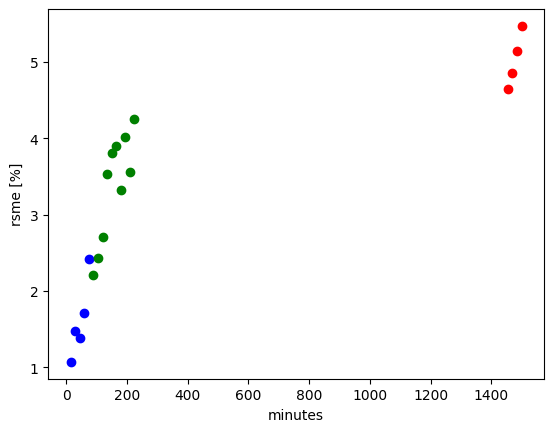

In [23]:
av=np.mean(ser_test.to_predict)
r1=np.loadtxt("xgb2_prelim_0-5_rsmse.txt")
r2=np.loadtxt("xgb2_prelim_96-100_rsmse.txt")
r3=np.loadtxt("xgb2_prelim_5-15_rsmse.txt")
print(r1.T)
print(r3.T)
print(r2.T)
plt.plot(r1[0]*15+15,r1[1]/av*100,'o',color='blue')
plt.plot(r2[0]*15+15,r2[1]/av*100,'o',color='red')
plt.plot(r3[0]*15+15,r3[1]/av*100,'o',color='green')
plt.xlabel("minutes")
plt.ylabel("rsme [%]")

Looks like something is wrong, maybe not always same gap is used. 

## Further improvement ideas
- Make feates les hard coded above
- Start year on 1 march because of 29 February.
- Add something special datawise for days infleunces by eastern, could be in main models or in special model only used sometimes
- Add more past (possible average) data points


In [121]:
#prediction function
#parameters, most recent features, list of model,delta ts, standard is just every 0.25 h from models
def predict_from_now2(data,models,deltas=None):
    print(data)
    if deltas==None:
        deltas=np.zeros((len(models)))
        for i in range(len(models)):
            deltas[i]=0.25+i/4
    res=np.zeros((3,len(models)))  
    res[0,:]=deltas
    for i in range(len(models)):
        print(i)
        xmodel=XGBRegressor()
        xmodel.load_model(models[i])
        #predict needs more than 1 data point to work 
        res[1,i]=xmodel.predict(data)[-1]
    #need better column names at some points in a data frame     
    return res     

In [22]:
print(comb_real_power.loc[comb_real_power.shape[0]-1,['total_power','frac_day', 'frac_week', 'frac_year']])
myPath='/home/tobias/ml-testing/energy/energy-timeseries'
models=[f for f in os.listdir(myPath) 
    if (f.startswith('xgb_model_')) and  (f.endswith('json') )] 
models.sort()
print(models)

KeyError: "['frac_day', 'frac_week', 'frac_year'] not in index"

In [123]:
prediction=predict_from_now(comb_real_power.loc[comb_real_power.shape[0]-3:comb_real_power.shape[0],['total_power','frac_day', 'frac_week', 'frac_year']],models[:])

        total_power  frac_day  frac_week  frac_year
315741     12.09550  0.968750   0.852679   0.004706
315742     11.83150  0.979167   0.854167   0.004734
315743     11.72175  0.989583   0.855655   0.004763
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191


In [124]:
prediction2=predict_from_now(comb_real_power.loc[comb_real_power.shape[0]-3:comb_real_power.shape[0]-2,['total_power','frac_day', 'frac_week', 'frac_year']],models[:])

        total_power  frac_day  frac_week  frac_year
315741      12.0955  0.968750   0.852679   0.004706
315742      11.8315  0.979167   0.854167   0.004734
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191


Seems to work and relatively fast, likely fats enough for doing it every 15 mimnutes.
Not crazy fast but good enough for now. 

[[11.         16.05557632]
 [11.25       16.3004055 ]
 [11.5        16.71058273]
 [11.75       16.44300652]
 [12.         16.55988121]
 [12.25       16.55244637]
 [12.5        16.56935883]]


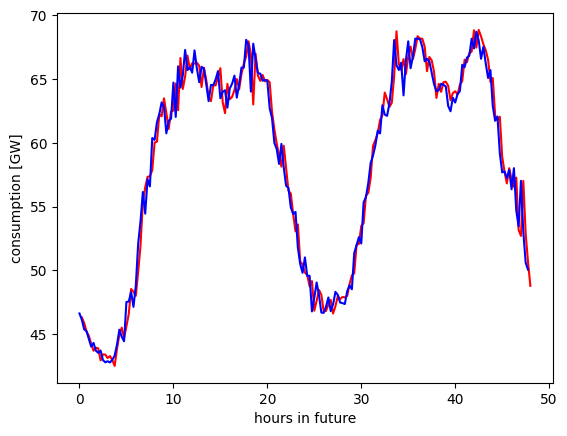

In [125]:
plt.plot(prediction[0],prediction[1]*4,color='red')
plt.plot(prediction2[0]-0.25,prediction2[1]*4,color='blue')
plt.xlabel("hours in future")
plt.ylabel("consumption [GW]")    
print(prediction[0:2,43:50].T)

LOoks plausible mostly, also not with much wiggles, but one is rather bad close to 10 hours. 
That seem to be general bad, rerun withg 20% offset regularization start. That solved the problem, others are more like noise without a clear wrong solution. 
Those wiggles are a kind of noise not really expected, whether bad depends on whether it should look better as it is or not. 

Still looks good that it can be implemented. 

## Further improvement ideas
- Need track metrics 
- Start year on 1 march because of 29 February.
- Add something special datawise for days infleunces by eastern, could be in main models or in special model only used sometimes
- Add more past (possible average) data points
